In [1]:
! pip install transformers datasets
! pip install evaluate
! pip install sentence-transformers
! pip install bitsandbytes
! pip install hf_xet
! pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import os
import warnings
os.environ["WANDB_MODE"] = "disabled"
warnings.filterwarnings("ignore", message=".*gather.*scalars.*")

### Προσοχή

Μη διαγράψετε τα # insert your code here σχόλια, καθώς βοηθούν στη διόρθωση. Συμπληρώστε τον κώδικά σας μετά από τα σχόλια αυτά.

# Μέρος Α: Fine-tune a pretrained model

Τα γλωσσικά μοντέλα αποτελούνται από δύο στάδια εκπαίδευσης:
1. **Pre-training σε μεγάλα unlabelled datasets**:

  Το pre-training είναι υπολογιστικά πολύ ακριβό και γι αυτό στην πράξη δε το χρησιμοποιούμε όταν θέλουμε να τρέξουμε ένα μοντέλο σε ένα καινούργιο dataset. Μπορούμε να σκεφτούμε το pre-training ως τη διαδικασία εκμάθησης γλωσσικών κανόνων κι εννοιών, οι οποίες στη συνέχεια μπορούν να χρησιμοποιηθούν για διάφορους σκοπούς.

2. **Fine-tuning σε μικρότερα labelled datasets**:
  
     Το fine-tuning πρακτικά εκμεταλλεύεται τις ιδιότητες του transfer learning προκειμένου να μεταφέρουμε τη 'γνώση' που έχει αποθηκευθεί στο γλωσσικό μοντέλο κατά τη διάρκεια του pre-training σε συγκεκριμένα task. Κάθε task εξυπηρετείται μέσω στοχευμένων datasets. Για παράδειγμα, κάποια datasets αναφέρονται στην ταξινόμηση κειμένων σε κατηγιορίες (text classification), άλλα datasets περιέχουν ερωτήσεις οι οποίες πρέπει να απαντηθούν (question answering) κι άλλα πολλά.

Κάποια κλασικά tasks της επεξεργασίας φυσικής γλώσσας είναι τα ακόλουθα:
- Text classification
- Question answering
- Natural language inference
- Fill mask
- Semantic similarity

Περισσότερες πληροφορίες μπορείτε να βρείτε στον ακόλουθο σύνδεσμο στο domain Natural Language Processing: https://huggingface.co/models

Στο πρώτο κομμάτι της παρούσας εργαστηριακής άσκησης, θα χρησιμοποιήσουμε το pre-training fine-tuning σενάριο για να ταξινομήσουμε reviews.

## Pipelines

Με τη χρήση του **text-classification pipeline** μπορούμε να τρέξουμε γλωσσικά μοντέλα που αφορούν tasks ταξινόμησης.

Το natural language inference (NLI) task αποτελεί ένα task ταξινόμησης, αφού το σχετικό μοντέλο (εν προκειμένω το roberta-large-mnli) καλείται να ταξινομήσει ένα κείμενο σε μία από τις 3 κατηγορίες: **[entailment/neutral/contradiction]**.

```
from transformers import pipeline

classifier = pipeline("text-classification", model = "roberta-large-mnli")
classifier("A soccer game with multiple males playing. Some men are playing a sport.")
## [{'label': 'ENTAILMENT', 'score': 0.98}]
```

Ένα άλλο task ταξινόμησης αφορά την αξιολόγηση του κατά πόσο ένα κείμενο είναι **γραμματικά ορθό (acceptable) ή όχι (unacceptable)**:

```
from transformers import pipeline

classifier = pipeline("text-classification", model = "textattack/distilbert-base-uncased-CoLA")
classifier("I will walk to home when I went through the bus.")
##  [{'label': 'unacceptable', 'score': 0.95}]
```

## Σύνολο δεδομένων Yelp polarity

Κατεβάζουμε το [Yelp Polarity](https://huggingface.co/datasets/yelp_polarity) dataset το οποίο περιέχει reviews που εκφράζουν συναισθήματα πελατών για εστιατόρια.
Το  Yelp κατασκευάστηκε θεωρώντας τα αστέρια 1 και 2 αρνητικά και τα 3 και 4 θετικά.  Η αρνητική πολικότητα ανήκει στην κατηγορία 1 και η θετική στην κατηγορία 2. Τα reviews αυτά χωρίζονται σε αυτές τις κατηγορίες, και ο σκοπός μας είναι να κατηγοριοποιήσουμε νέα reviews στις σωστές κατηγορίες.



In [ ]:
from datasets import load_dataset

# insert your code here
dataset = load_dataset("fancyzhx/yelp_polarity")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Επειδή το σύνολο δεδομένων του Yelp Polarity περιέχει πολλά δείγματα, προκειμένου να επιταχύνουμε τη διαδικασία του fine-tuning συστήνουμε να διατηρήσετε 300 δείγματα από το train set και 300 δείγματα από το test set.

Ελέγξτε τον αριθμό κατηγοριών που υπάρχουν συνολικά στο train και το test set και διατηρήστε ισορροπημένο αριθμό δειγμάτων ανά κατηγορία για τα σύνολα αυτά κατά την επιλογή των 300 δειγμάτων.

In [ ]:
# insert your code here
from datasets import load_dataset
from collections import Counter
import random

dataset = load_dataset("fancyzhx/yelp_polarity")

train_dataset = dataset['train']
test_dataset = dataset['test']

# check a random entry

num_rows = len(train_dataset)
random_num = random.randint(0, num_rows - 1)
random_row = train_dataset[random_num]
print("Random Entry in the training dataset: ", random_row)

labels = [example['label'] for example in train_dataset]
label_counts = Counter(labels)
print("Original labels count", label_counts)

#the distribution is 50-50
sample_size = 300

def sample_dataset(dataset):
    label_counts = Counter(dataset['label'])
    total_samples = len(dataset)
    sampled_indices = []

    for label, count in label_counts.items():
        proportion = count / total_samples
        num_to_sample = int(proportion * sample_size)

        indices_with_label = [i for i, example in enumerate(dataset) if example['label'] == label]

        sampled_indices.extend(random.sample(indices_with_label, min(num_to_sample, len(indices_with_label))))

    random.shuffle(sampled_indices)

    sampled_dataset = dataset.select(sampled_indices)
    return sampled_dataset

train_dataset = sample_dataset(train_dataset)
labels = [example['label'] for example in train_dataset]
label_counts = Counter(labels)
# print("Sampled labels count", label_counts)

test_dataset = sample_dataset(test_dataset)


Random Entry in the training dataset:  {'text': 'I had the meatloaf and a was great - baked well with a little char on the outside. Nice staff and the bar has plenty of tvs and a patio', 'label': 1}
Original labels count Counter({0: 280000, 1: 280000})


In [ ]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 300
})
Dataset({
    features: ['text', 'label'],
    num_rows: 300
})


# Language Models

Η προεπεξεργασία των κειμένων προηγείται της εισόδου τους στα γλωσσικά μοντέλα.

Η διαδικασία αυτή επιτελείται μέσω των **Tokenizers**, τα οποία μετατρέπουν τα tokens εισόδου σε κατάλληλα IDs του λεξιλογίου προεκπαίδευσης, κι έτσι μετατρέπουν το κείμενο σε μορφή που μπορεί να επεξεργαστεί κάποιο μοντέλο Transformer. Η βιβλιοθήκη Huggingface προσφέρει εύκολες και high-level υλοποιήσεις tokenization, τις οποίες συστήνουμε να ακολουθήσετε στη συνέχεια.

Συγκεκριμένα, **αρχικοποιούμε τη διαδικασία του tokenization με χρήση του AutoTokenizer**. Επιλέγοντας τη μέθοδο **from_pretrained** λαμβάνουμε έναν tokenizer που αποκρίνεται στην αρχιτεκτονική του μοντέλου που επιθυμούμε να χρησιμοποιήσουμε, παρέχοντας συμβατό tokenization.

Περισσότερες πληροφορίες για το AutoTokenization μπορείτε να βρείτε εδώ:
https://huggingface.co/docs/transformers/model_doc/auto

Αναφορικά με το μοντέλο BERT, μπορείτε να δείτε τη διαδικασία [του tokenization και της αρχικοποίησης του μοντέλου](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer):

```
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
```

Στα πλαίσια της άσκησης καλείστε να επιτελέσετε την παραπάνω διαδικασία με *κάποιο άλλο μοντέλο της επιλογής σας από το Huggingface* που να υποστηρίζει τον AutoTokenizer. Το pre-trained μοντέλο που θα επιλέξετε θα πρέπει να διαθέτει υλοποίηση με sequence classification head (κατ αναλογία της μεθόδου BertForSequenceClassification).

Στο επόμενο κελί, φορτώστε το επιλεχθέν μοντέλο με τον αντίστοιχο tokenizer.

(Αγνοήστε πιθανά warnings της μορφής Some weights of the model checkpoint at xxx were not used when initializing...)

In [ ]:
# insert your code here
from transformers import AutoTokenizer, DistilBertForSequenceClassification

#initially Ernie was chosen, however the accuracy was too high from the first epoch
#therefore it was difficult to get any meaningful data from fine-tuning

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# ensure padding is to the right as per the documentation
# print(f"Padding: {tokenizer.padding_side}")

model = DistilBertForSequenceClassification.from_pretrained(model_name)

# print(tokenizer)
# print(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Σας παρέχουμε τη συνάρτηση που πραγματοποιεί το tokenization καλώντας τον tokenizer που επιλέξατε. Εφαρμόστε το τόσο στο train, όσο και στο test set.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# insert your code here
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Τυπώνοντας το train ή το test set, θα δείτε δύο επιπλέον πεδία 'input_ids' και 'attention_mask'. Βεβαιωθείτε ότι υπάρχουν, άρα και το tokenization έχει επιτευχθεί.

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 300
})

## Χρήση του PyTorch Trainer για fine-tuning

Η κλάση [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) έχει βελτιστοποιηθεί από τους δημιουργούς του Huggingface παρέχοντας πολλές διευκολύνσεις και λιγότερη 'χεράτη' δουλειά. Προτείνουμε να τη χρησιμοποιήσετε ως εναλλακτική του να γράψετε το δικό σας training loop.
Καθώς η Trainer δεν τεστάρει αυτόματα την επίδοση του εκάστοτε μοντέλου κατά την εκπαίδευση, παρέχουμε κατάλληλη συνάρτηση προκειμένου να αποτιμάται το accuracy του μοντέλου σε κάθε εποχή.

In [ ]:
import numpy as np
import evaluate
import torch
from tqdm import tqdm
from transformers import pipeline

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Η κλάση [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) περιέχει όλες τις υπερπαραμέτρους με τις οποίες μπορείτε να πειραματιστείτε κατά τη διαδικασία fine-tuning.


Καλείστε να πειραματιστείτε με διαφορετικές υπερπαραμέτρους όπως το learning rate, batch size κλπ, καθώς επίσης και να ορίσετε optimizer και scheduler για το fine-tuning. Προτείνουμε να εκτελέσετε fine-tuning για μικρό αριθμό εποχών (άλλωστε το μοντέλο είναι ήδη προεκπαιδευμένο).

1. Θα μας δώσετε σε markdown ένα πινακάκι με διαφορετικές υπερπαραμέτρους που δοκιμάσατε και το accuracy που πετύχατε στην τελευταία εποχή.

2. Βάσει των πειραματισμών, πώς επηρεάζουν διαφορετικές υπερπαράμετροι όπως το learning rate και το batch size το fine-tuning του μοντέλου που επιλέξατε;  Σχολιάστε και αναλύστε.

In [ ]:
from transformers import TrainingArguments, Trainer

args = [None] * 12

args[0] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=2e-5)


# insert your code here
# optimizer
# the default optimizer per the documentation is ADAMW_TORCH. we will try two more
args[1] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    optim = "lion_8bit")

args[2] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=1e-4,
    optim="adafactor",
)

# scheduler
# the default scheduler is linear. we will try two more
# we have chosen the optimizer as LION
optimizer = "lion_8bit"
args[3] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    optim = optimizer,
    lr_scheduler_type = "cosine")

args[4] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    optim = optimizer,
    lr_scheduler_type = "constant")

# etc
# we figured out that different schedulers yield the same results
# therefore from here on we choose linear
# we will now experiment with lr, batch_size and weight decay
scheduler = "constant"

# LR High
args[5] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-5,
    optim = optimizer,
    weight_decay=0.0,
    lr_scheduler_type = scheduler
    )

#LR Low
args[6] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-7,
    weight_decay=0.0,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

#BS Small
args[6] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    optim = optimizer,
    weight_decay=0.0,
    lr_scheduler_type = scheduler
    )

#BS Large
args[7] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    weight_decay=0.0,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

#WD Small
args[7] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    weight_decay=0.001,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

#WD Large
args[8] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    weight_decay=0.01,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

#LR High + WD
args[9] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-5,
    weight_decay=0.01,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

#LR Low + BS Large
args[10] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-7,
    weight_decay=0.0,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

#BS Small + WD
args[11] = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=5e-6,
    weight_decay=0.005,
    optim = optimizer,
    lr_scheduler_type = scheduler
    )

In [ ]:
trainer = Trainer(
    model=model,
    args=args[1],
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


Στη συνέχεια, ρυθμίστε (fine-tune) το μοντέλο σας καλώντας το [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
trained_model=trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.686291,0.503333
2,No log,0.674719,0.563333
3,No log,0.652134,0.790000
4,No log,0.607192,0.843333
5,No log,0.536794,0.880000
6,No log,0.462798,0.880000
7,No log,0.397290,0.890000
8,No log,0.346415,0.900000
9,No log,0.313033,0.906667
10,No log,0.291292,0.910000


| i |  args  | evaluation |
|:-:| :----: | :--------: |
|0 | lr=2e-5, BS=16, WD=0, O=AdamW, S=linear     | 90% |
|1 | lr=5e-6, BS=16, WD=0, O=LION, S=linear      | 93% |
|2 | lr=1e-3, BS=16, WD=0, O=adafactor, S=linear | 90% |
|3 | lr=5e-6, BS=16, WD=0, O=LION, S=cosine      | 89% |
|4 | lr=5e-6, BS=16, WD=0, O=LION, S=constant    | 92% |
|5 | lr=5e-5, BS=16, WD=0, O=LION, S=constant    | 85% |
|6 | lr=5e-7, BS=8 , WD=0, O=LION, S=constant    | 89% |
|7 | lr=5e-6, BS=16, WD=0.001, O=LION, S=constant| 90% |
|8 | lr=5e-6, BS=8 , WD=0.01, O=LION, S=constant | 93% |
|9 | lr=5e-5, BS=16, WD=0.01, O=LION, S=constant | 81% |
|10| lr=5e-7, BS=32, WD=0, O=LION, S=constant    | 72% |
|11| lr=5e-6, BS=8 , WD=0.005, O=LION, S=constant| 86% |




# Ανάλυση Optimizers

- Ο προεπιλεγμένος **AdamW** με `lr=2×10⁻⁵` και `BS=16` αποδίδει **90%**.  
- Έπειτα δοκιμάζουμε τον **LION**, με `lr=5×10⁻⁶` (περίπου το 1/4 αυτού του AdamW, κοντά στη σύσταση του paper) και ίδιο `BS=16`, και πετυχαίνουμε **93%**.  
- Τέλος, δοκιμάζουμε και τον **Adafactor** με `lr=1×10⁻³` (όπως συχνά προτείνεται για αυτόν τον optimizer) και `BS=16`, ο οποίος επιτυγχάνει **90%**.

> **Παρατήρηση:** Ο LION φαίνεται να δίνει το καλύτερο αποτέλεσμα σε αυτή τη σύγκριση. Από εδώ και στο εξής, θα χρησιμοποιήσουμε τον LION για τις υπόλοιπες δοκιμές.

---

# Ανάλυση Schedulers

Χρησιμοποιώντας **LION**, `lr=5×10⁻⁶`, `BS=16`:

- **Linear scheduler** : **93%**  
- **Cosine scheduler** : **89%**
- **Constant scheduler** : **92%**

> **Παρατήρηση:** Ο linear scheduler έδωσε, οριακά, καλύτερο αποτέλεσμα από τον constant. Όμως, δεδομένου ότι ο optimizer που χρησιμοποιούμε είναι adaptive, δηλαδή ρυθμίζει και ο ίδιος το lr, επιλέγουμε τον constant ώστε να μην έχουμε δύο μηχανισμούς να επενεργούν ταυτόχρονα στην ίδια υπερπαράμετρο.

---

# Ανάλυση Learning Rate (lr)

Με **LION** και **constant scheduler**:

- `lr=5×10⁻⁶` (δοκιμή 4, BS=16): **92%**
- `lr=5×10⁻⁵` (δοκιμή 5, BS=16): **85%**
- `lr=5×10⁻⁵` + `WD=0.01` (δοκιμή 9): **81%**
- `lr=5×10⁻⁷` (δοκιμή 6, BS=8): **89%**
- `lr=5×10⁻⁷` (δοκιμή 10, BS=32): **72%**

> **Παρατήρηση:** Το `lr=5×10⁻⁶` φαίνεται να είναι η βέλτιστη επιλογή. Τόσο υψηλότερες όσο και χαμηλότερες τιμές μείωσαν την απόδοση.

---

# Ανάλυση Batch Size (BS)

Με **LION** και **constant scheduler**:

- `BS=16`, `lr=5×10⁻⁶`, `WD=0` (δοκιμή 4): **92%**
- `BS=8`, `lr=5×10⁻⁷`, `WD=0` (δοκιμή 6): **89%**
- `BS=8`, `lr=5×10⁻⁶`, `WD=0.01` (δοκιμή 8): **93%**
- `BS=8`, `lr=5×10⁻⁶`, `WD=0.005` (δοκιμή 11): **86%** *(peak στο 92%)*
- `BS=32`, `lr=5×10⁻⁷`, `WD=0` (δοκιμή 10): **72%**

> **Παρατήρηση:** Το `BS=32` είναι ακατάλληλο. Το `BS=8` με `WD=0.01` έδωσε το καλύτερο αποτέλεσμα.

---

# Ανάλυση Weight Decay (WD)

Με **LION**, **constant scheduler**, `lr=5×10⁻⁶`:

- `WD=0` (δοκιμή 4, BS=16): **92%**
- `WD=0.001` (δοκιμή 7, BS=16): **90%**
- `WD=0.01` (δοκιμή 8, BS=8): **93%**
- `WD=0.005` (δοκιμή 11, BS=8): **86%** *(με peak στο 92%)*
- `WD=0.01`, `lr=5×10⁻⁵` (δοκιμή 9, BS=16): **81%**

> **Παρατήρηση:** Το `WD=0.01` συνδυασμένο με `BS=8` και το σωστό `lr` έδωσε τη βέλτιστη απόδοση. Μικρότερες τιμές WD δεν φάνηκαν εξίσου αποτελεσματικές. Η πτώση στη δοκιμή 11 υποδεικνύει πιθανή αστάθεια ή overfitting.

---

### Βέλτιστες Παράμετροι (93%):

1. **Δοκιμή 1**: `LION`, `lr=5×10⁻⁶`, `BS=16`, `WD=0`, **Linear Scheduler**
2. **Δοκιμή 8**: `LION`, `lr=5×10⁻⁶`, `BS=8`, `WD=0.01`, **Constant Scheduler**

> **Σχόλιο:** Στη δοκιμή 11 παρατηρήθηκε peak 92%, final 86%. Αυτό υπογραμμίζει τη σημασία του **early stopping** και του **monitoring** κατά τη διάρκεια της εκπαίδευσης.


# Μέρος Β: Χρήση fine-tuned μοντέλων σε νέα tasks

Στο κομμάτι αυτό της εργασίας δε χρειάζεται να πραγματοποιήσετε εκπαίδευση σε γλωσσικά μοντέλα. Αντιθέτως, θα εκμεταλλευτούμε τις δυνατότητες του transfer learning για να αντιμετωπίσουμε πιο πολύπλοκα γλωσσικά task, ανάγοντάς τα σε κλασικά task όπως είναι το text classification, natural language inference, question answering και άλλα.

Για παράδειγμα, fine-tuned μοντέλα για [text classification](https://huggingface.co/tasks/text-classification) εξυπηρετούν tasks όπως:

- Είναι δύο προτάσεις η μία παράφραση της άλλης? [Paraphrase/No Paraphrase]
- Συνεπάγεται η πρόταση Χ την πρόταση Υ? [Entail/Neutral/Contradict]
- Είναι η δοθείσα πρόταση γραμματικά ορθή? [Acceptable/Unacceptable]

## B1. Piqa dataset

Το [Piqa dataset](https://huggingface.co/datasets/piqa) περιλαμβάνει προτάσεις οι οποίες ελέγχουν το βαθμό στον οποίο τα language models έχουν κοινή λογική (commonsense). Συγκεκριμένα, αποτελείται από προτάσεις και πιθανά endings, τα οποία απαιτούν commonsense γνώση για να συμπληρωθούν.

Για παράδειγμα, έχοντας την πρόταση "When boiling butter, when it's ready, you can" υπάρχουν δύο υποψήφια endings:
- "Pour it onto a plate"
- "Pour it into a jar"

Ένας άνθρωπος μπορεί να συμπεράνει ότι η δεύτερη πρόταση αποτελεί ένα πιο κατάλληλο ending, αφού το λιωμένο βούτυρο είναι υγρό, άρα το βάζο είναι ένα καταλληλότερο δοχείο σε σχέση με το πιάτο.

Για λόγους επιτάχυνσης επιλέξτε ένα τυχαίο υποσύνολο 100 δειγμάτων από το Piqa.

In [ ]:
# insert your code here (load dataset)
import datasets
import random

dataset = datasets.load_dataset("piqa", split="validation", trust_remote_code=True)

# 100 random samples
dataset = dataset.shuffle(seed=17).select(range(100))

# print(piqa_sample[0])

README.md:   0%|          | 0.00/8.41k [00:00<?, ?B/s]

piqa.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

Μπορούμε να θεωρήσουμε το παραπάνω σενάριο σαν ένα πρόβλημα πολλαπλής επιλογής, όπου υπάρχουν δύο πιθανές εναλλακτικές για το ending της πρότασης. Συνεπώς, αξιοποιώντας σχετικά μοντέλα μπορούμε να επιλύσουμε την επιλογή του ending δοθείσας της πρότασης.

Καλείστε λοιπόν να καταγράψετε το accuracy πρόβλεψης endings για κάθε πρόταση με χρήση γλωσσικών μοντέλων. Για λόγους σύγκρισης χρησιμοποιήστε τουλάχιστον 5 κατάλληλα μοντέλα.

In [ ]:
# insert your code here (models)
from transformers import pipeline
import torch
import collections
import gc

model_names = [
    "facebook/bart-large-mnli",
    "roberta-large-mnli",
    "microsoft/deberta-large-mnli",
    "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    "valhalla/distilbart-mnli-12-1"
]

classifiers = collections.OrderedDict()

for model in model_names:
    classifiers[model] = pipeline(
        "zero-shot-classification",
        model=model,
        device=0
    )

Device set to use cuda:0
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/890M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/890M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# insert your code here (function for ending prediction)

# we will iterate through the dataset, classifying each entry
# with all the models

# ensure order
model_results = collections.OrderedDict()
for model_name in classifiers.keys():
    # stats for each model
    model_results[model_name] = {'correct': 0, 'total': 0}

for i, example in enumerate(dataset):
    goal = example['goal']
    sol1 = example['sol1']
    sol2 = example['sol2']
    correct_label = example['label']
    solution = sol1 if correct_label == 0 else sol2
    labels = [sol1, sol2]

    if (i + 1) % 10 == 0: # progress report
        print(f"Progress: {i+1}/100")

    for model_name, classifier_pipe in classifiers.items():
        result = classifier_pipe(
            goal,
            labels
        )

        predicted = result['labels'][0]

        model_results[model_name]['total'] += 1

        if predicted == solution:
            model_results[model_name]['correct'] += 1


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Progress: 10/100


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


In [ ]:
for model_name, results_data in model_results.items():
    total_processed = results_data['total']
    correct_predictions = results_data['correct']

    accuracy = (correct_predictions / total_processed) * 100
    print(f"  Model: {model_name} -> Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_processed})")

  Model: facebook/bart-large-mnli -> Accuracy: 62.00% (62/100)
  Model: roberta-large-mnli -> Accuracy: 58.00% (58/100)
  Model: microsoft/deberta-large-mnli -> Accuracy: 68.00% (68/100)
  Model: MoritzLaurer/mDeBERTa-v3-base-mnli-xnli -> Accuracy: 61.00% (61/100)
  Model: valhalla/distilbart-mnli-12-1 -> Accuracy: 66.00% (66/100)


In [ ]:
del classifiers
gc.collect()
torch.cuda.empty_cache()

## B2. Truthful QA

### Sentence Transformers

Οι **sentence transformers** χρησιμοποιούνται για να δημιουργήσουν **embeddings προτάσεων**, δηλαδή διανυσματικές αναπαραστάσεις των προτάσεων αυτών σε ένα διανυσματικό χώρο. Χάρη στον τρόπο που έχουν προεκπαιδευτεί, έχουν την ικανότητα να τοποθετούν νοηματικά όμοιες προτάσεις κοντά τη μία στην άλλη, ενώ απομακρύνουν νοηματικά μακρινές προτάσεις. Έτσι, χάρη στις αναπαραστάσεις που λαμβάνουμε από τα sentence embeddings μπορούμε να αξιολογήσουμε σε τι βαθμό δύο προτάσεις είναι κοντά ή μακριά νοηματικά.

Η σύγκριση των διανυσματικών αναπαραστάσεων μπορεί να γίνει κλασικά μέσω μεθόδων όπως το consine similarity, με μεγαλύτερες τιμές μεταξύ διανυσμάτων να σηματοδοτούν πιο όμοια διανύσματα, άρα και πιο όμοιες προτάσεις. Δίνουμε για το λόγο αυτό μια συνάρτηση υπολογισμού του cosine similarity.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

Για παράδειγμα, εκτελέστε το ακόλουθο κελί, το οποίο δίνει μια τιμή ομοιότητας στο διάστημα [0, 1] για δύο προτάσεις ("This is an example sentence", "Each sentence is converted"). Μπορείτε ακόμα να δοκιμάσετε να εκτελέσετε το ακόλουθο κελί για διαφορετικές προτάσεις της επιλογής σας, που μπορεί να είναι όμοιες ή πολύ διαφορετικές μεταξύ τους, και να παρατηρήσετε τις αλλαγές τιμών του cosine similarity.

In [9]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)

get_cosine_similarity(embeddings[0], embeddings[1])

np.float32(0.4048847)

Για τη συνέχεια της άσκησης, καλείστε να επιλέξετε τουλάχιστον 6 διαφορετικά [μοντέλα για semantic similarity](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads) από τους sentence transformers

### Μπορούν τα question answering μοντέλα να διαχωρίσουν αληθείς και ψευδείς προτάσεις?

Αυτό το ερώτημα θα το απαντήσουμε στο παρόν κομμάτι της άσκησης. Για το λόγο αυτό, φορτώνουμε το dataset [Truthful QA generation](https://huggingface.co/datasets/truthful_qa/viewer/generation/validation), το οποίο περιέχει τις εξής επιλογές:

- best answer
- correct answer
- incorrect answer

Πολλές φορές το best answer και το correct answer είναι ίδια ή έστω πολύ κοντινά νοηματικά. Σε αυτό το σημείο είναι που θα αξιοποιήσουμε το semantic similarity για να αξιολογήσουμε την ομοιότητα αυτή.

Φιλτράρουμε το dataset ώστε να περιέχονται 100 δείγματα συνολικά για λόγους επιτάχυνσης, εκ των οποίων καθένα θα πρέπει να περιέχει τουλάχιστον 2 correct answer. Θεωρούμε έτσι 4 υποψήφιες επιλογές:

1η επιλογή: best answer  
2η επιλογή: 1ο correct answer  
3η επιλογή: 2ο correct answer  
4η επιλογή: incorrect answer  

Οι επιλογές αυτές μαζί με την ερώτηση δίνονται σε ένα μοντέλο πολλαπλής επιλογής σαν αυτά που χρησιμοποιήθηκαν στο ερώτημα Β1. Μπορείτε να θεωρήσετε τα ίδια μοντέλα και να τα επεκτείνετε σε 4 υποψήφιες απαντήσεις.  

Το semantic similarity θα επηρεάσει το τι θεωρούμε βέλτιστα σωστή απάντηση, άρα και το accuracy. Συγκεκριμένα, θα λάβουμε διανυσματικές αναπαραστάσεις για το best answer και τα 2 correct answer που έχουν δοθεί ως υποψήφιες επιλογές μέσω κάποιου semantic similarity μοντέλου. Σε περίπτωση λοιπόν που το μοντέλο πολλαπλής επιλογής προβλέψει ένα εκ των correct answer, και η ομοιότητά τους σε σχέση με το best model ξεπερνάει ένα προεπιλεγμένο κατώφλι ομοιότητας, η απάντηση θεωρείται βέλτιστα σωστή. Θέτουμε λοιπόν κατώφλι ομοιότητας το 0.95.

Για παράδειγμα, έστω ότι το μοντέλο πολλαπλής επιλογής μεταξύ των υποψηφίων [best, 1st correct, 2nd correct, incorrect] επιλέγει το δεύτερο στοιχείο, δηλαδή το 1st correct, και δεδομένου ότι το cosine similarity μεταξύ των embeddings του best και του 1st correct είναι > 0.95, τότε θεωρούμε ότι η απάντηση είναι βέλτιστα σωστή, και συνυπολογίζεται θετικά στο accuracy.

Καλείστε λοιπόν να γράψετε μια συνάρτηση που να υπολογίζει το accuracy εύρεσης βέλτιστα σωστών απαντήσεων ανάμεσα στις υποψήφιες απαντήσεις, εξετάζοντας τουλάχιστον 6 semantic similarity μοντέλα καθώς επίσης και τα μοντέλα που επιλέξατε στο ερώτημα Β1.


In [2]:
# insert your code here (load dataset)
import datasets
import random

dataset = datasets.load_dataset("truthful_qa", "generation", split="validation")
eval_dataset = []
# ensure each entry has at least 3 distinct correct answers and one wrong
def is_valid(entry):
    return len(entry['correct_answers']) >= 3 and len(entry['incorrect_answers']) >= 1

filtered_dataset = dataset.filter(is_valid)
eval_dataset = filtered_dataset.shuffle(seed=17).select(range(100))


# print(eval_dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.59k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/817 [00:00<?, ? examples/s]

In [3]:
# insert your code here (load models for semantic similarity and QA)
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch
import collections
import gc


st_model_names = [
    'all-mpnet-base-v2',
    'all-MiniLM-L6-v2',
    'paraphrase-multilingual-mpnet-base-v2',
    'stsb-roberta-large',
    'sentence-t5-large',
    'distiluse-base-multilingual-cased-v1'
]

qa_model_names = [
    "facebook/bart-large-mnli",
    "roberta-large-mnli",
    "microsoft/deberta-large-mnli",
    "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli",
    "valhalla/distilbart-mnli-12-1"
]

st_models = collections.OrderedDict()
qa_classifiers = collections.OrderedDict()

for st_name in st_model_names:
    st_models[st_name] = SentenceTransformer(st_name)

for qa_name in qa_model_names:
    qa_classifiers[qa_name] = pipeline(
        "zero-shot-classification",
        model=qa_name,
        device=0
    )

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/890M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/890M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
# insert your code here (function for ending prediction)

results = collections.OrderedDict()

for qa_name in qa_classifiers.keys():
    results[qa_name] = collections.OrderedDict()
    for st_name in st_models.keys():
      results[qa_name][st_name] = {'correct': 0, 'total': 0, 'first_try_correct': 0}

total_examples_processed = 0

for i, example in enumerate(eval_dataset):
    total_examples_processed += 1
    if (i + 1) % 10 == 0:
        print(f"Progress: {i + 1}/100")

    question = example['question']
    best_answer = example['best_answer']

    correct_answer_1 = example['correct_answers'][0]
    correct_answer_2 = example['correct_answers'][1]
    incorrect_answer = example['incorrect_answers'][0]

    candidate_answers = [best_answer, correct_answer_1, correct_answer_2, incorrect_answer]
    answers_to_embed = [best_answer, correct_answer_1, correct_answer_2]

    for st_name, st_model in st_models.items():
        embeddings = st_model.encode(answers_to_embed, show_progress_bar=False)

        sim_best_correct1 = get_cosine_similarity(embeddings[0], embeddings[1])
        sim_best_correct2 = get_cosine_similarity(embeddings[0], embeddings[2])

        for qa_name, qa_classifier in qa_classifiers.items():
            qa_result = qa_classifier(
                question,
                candidate_answers,
                )
            predicted_answer = qa_result['labels'][0]

            results[qa_name][st_name]['total'] += 1

            correct = False
            if predicted_answer == best_answer:
                correct = True
                results[qa_name][st_name]['first_try_correct'] += 1
            elif predicted_answer == correct_answer_1 and sim_best_correct1 > 0.95:
                correct = True
            elif predicted_answer == correct_answer_2 and sim_best_correct2 > 0.95:
                correct = True

            if correct:
                 results[qa_name][st_name]['correct'] += 1

Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100


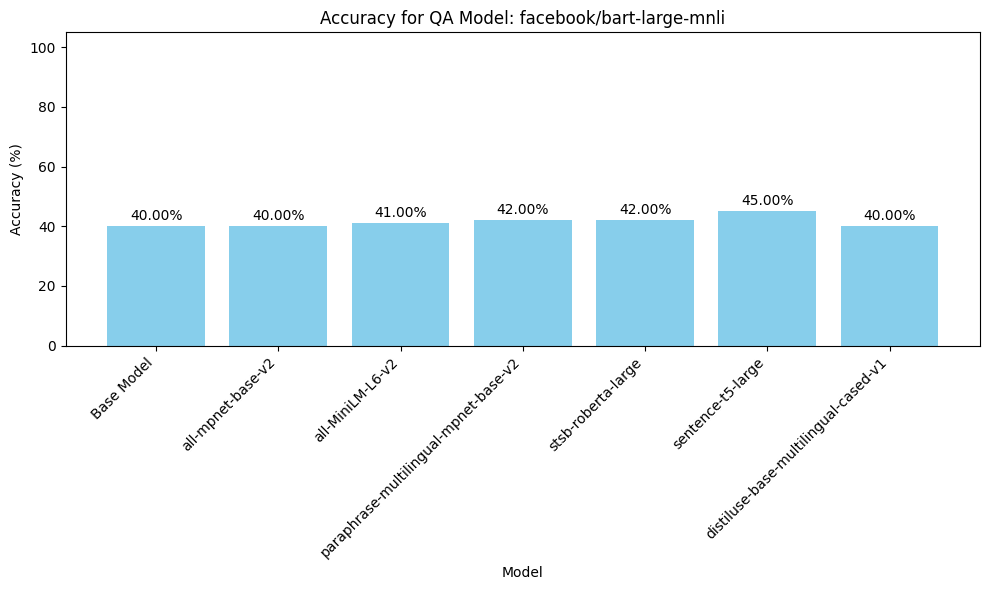

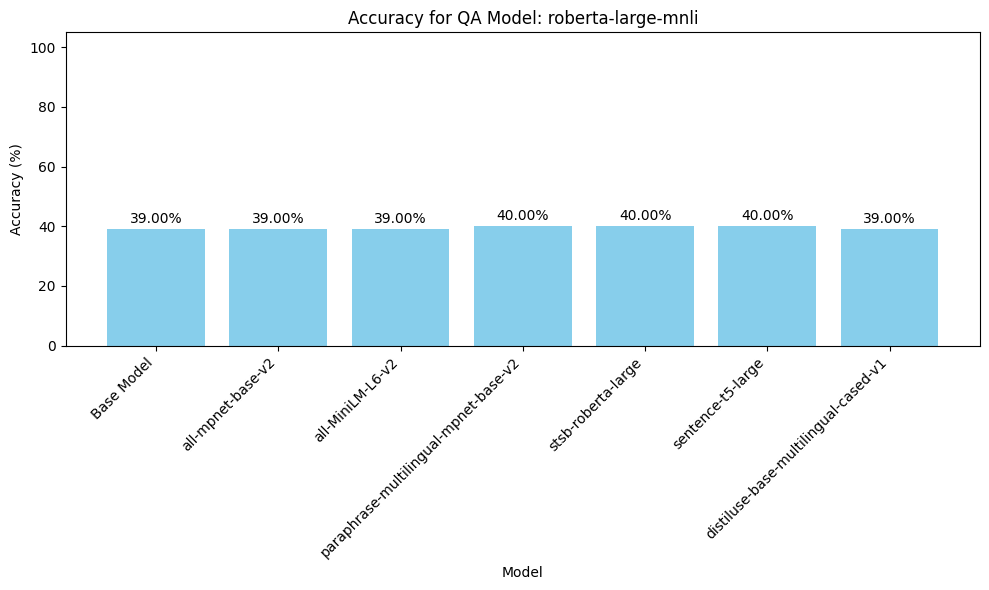

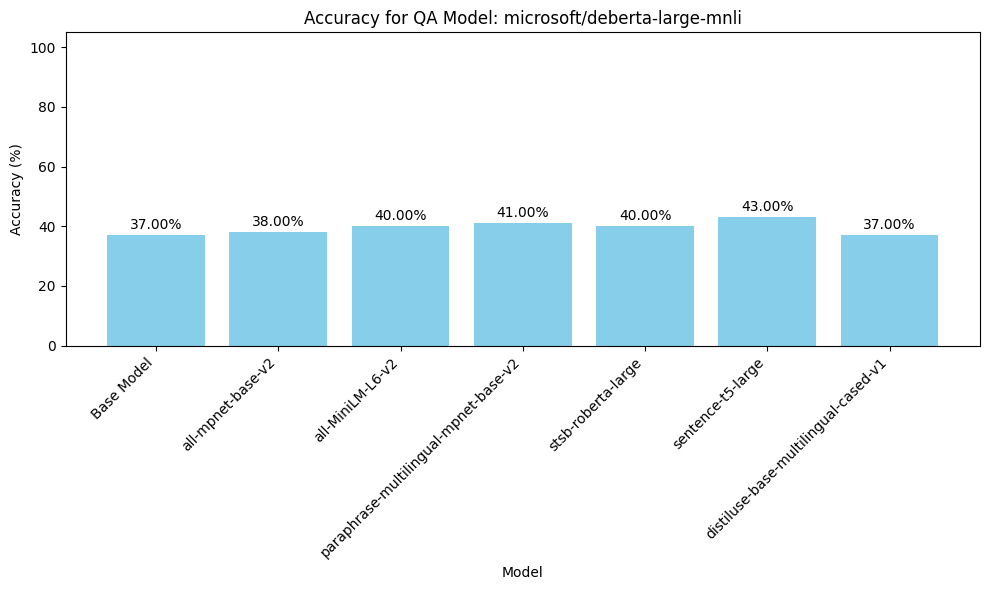

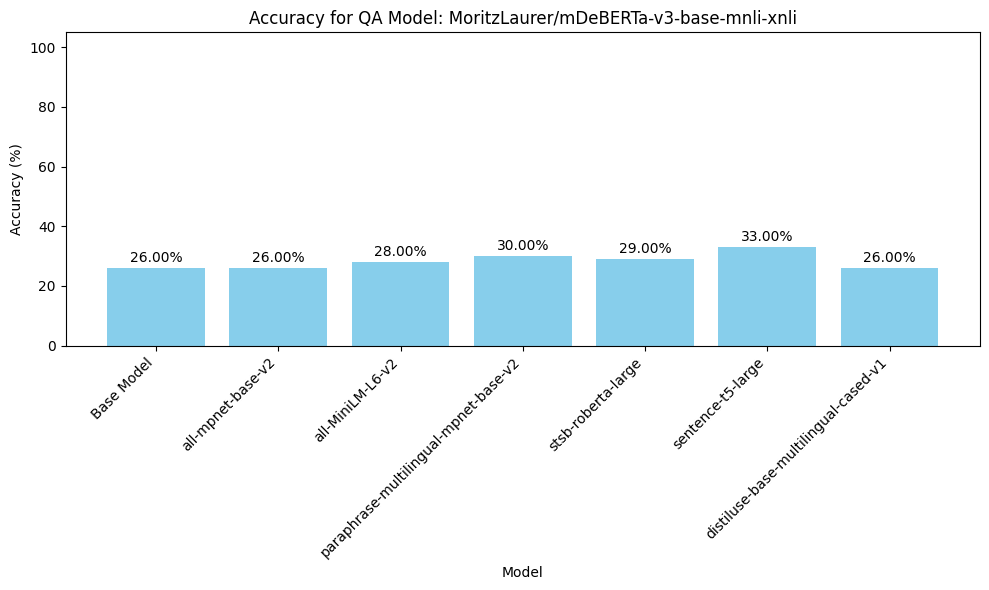

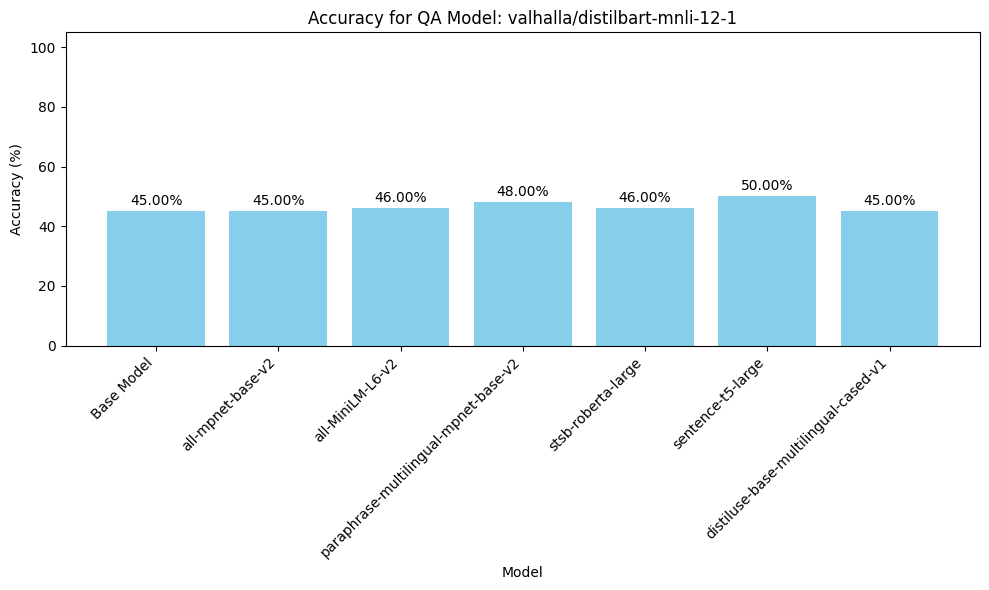

In [16]:
import matplotlib.pyplot as plt

st_model_names_for_labels = list(st_models.keys())

for qa_name, st_results_dict in results.items():

    first_st = st_model_names_for_labels[0]
    ft = st_results_dict[first_st]
    baseline_acc = (ft['first_try_correct'] / ft['total']) * 100

    accuracies = [baseline_acc]
    st_names_found = ['Base Model']

    for st_name in st_model_names_for_labels:
        rd = st_results_dict[st_name]
        acc = (rd['correct'] / rd['total']) * 100
        accuracies.append(acc)
        st_names_found.append(st_name)

    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(st_names_found, accuracies, color='skyblue')

    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Model')
    ax.set_title(f'Accuracy for QA Model: {qa_name}')
    ax.set_ylim(0, 105)
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + 1,
            f'{yval:.2f}%',
            va='bottom',
            ha='center'
        )

    plt.tight_layout()
    plt.show()


In [17]:
del st_models
del qa_classifiers
gc.collect()
torch.cuda.empty_cache()


## Β3. Winogrande dataset

Το [Winogrande dataset](https://huggingface.co/datasets/winogrande) αποτελείται από προτάσεις που μία λέξη τους έχει αφαιρεθεί και δίνονται δύο πιθανές επιλογές συμπλήρωσης του κενού. Για παράδειγμα, δοθείσας της πρότασης "John moved the couch from the garage to the backyard to create space. The _ is small.", υπάρχουν δύο πιθανές εναλλακτικές:

- "garage"
- "backyard"

Η δυσκολία της συμπλήρωσης έγκειται στο ότι και οι δύο λέξεις αναφέρονται στην πρόταση, οπότε το μοντέλο θα πρέπει να διαθέτει υψηλές δυνατότητες κατανόησης γλώσσας προκειμένου να επιλέξει μια νοηματικά σωστή συμπλήρωση.

Για λόγους επιτάχυνσης, επιλέξτε ένα τυχαίο υποσύνολο 100 δειγμάτων από το training set του Winogrande.


In [ ]:
# insert your code here (load dataset)
import datasets
import random

dataset = datasets.load_dataset("winogrande", "winogrande_xl", split="validation", trust_remote_code=True)
dataset = dataset.shuffle(seed=17).select(range(100))

print(dataset[0])

{'sentence': "Patricia has a trouble with training her horse and wants Tanya's help, because _ wants her horse to behave.", 'option1': 'Patricia', 'option2': 'Tanya', 'answer': '1'}


Με κατάλληλο [μετασχηματισμό](https://huggingface.co/DeepPavlov/roberta-large-winogrande) της παραπάνω εισόδου (πρόταση με κενό και δύο επιλογές συμπλήρωσης), καλείστε να καταγράψετε το accuracy σχετικών μοντέλων που επιλύουν το πρόβλημα, συγκρίνοντας το predicted label με το πραγματικό label (1: πρώτη επιλογή, 2: δεύτερη επιλογή). Ουσιαστικά θα πρέπει να αναγάγετε το παραπάνω πρόβλημα σε κάποιο πιο κλασικό πρόβλημα της επεξεργασίας φυσικής γλώσσας.

Δοκιμάστε τουλάχιστον 3 κατάλληλα μοντέλα από το Huggingface για να προσεγγίσετε το πρόβλημα του Winogrande. Προτείνουμε τη χρήση pipelines για τη διευκόλυνσή σας.

In [ ]:
# insert your code here (load models)
model_names = [
  "facebook/bart-large-mnli",
  "roberta-large-mnli",
  "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"
]

In [ ]:
# insert your code here (create pipelines)
from transformers import pipeline
import torch
import collections
import gc

pipelines = collections.OrderedDict()
candidate_labels = ["correct context", "incorrect context"]

print("\nLoading pipelines...")
for model_name in model_names:
    pipelines[model_name] = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=0
    )

gc.collect()
torch.cuda.empty_cache()


Loading pipelines...


Device set to use cuda:0
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing Ro

In [ ]:
# insert your code here (function for predicting best fill)

# first we transform the dataset

data = []

for i, example in enumerate(dataset):
  if (i + 1) % 50 == 0:
      print(f" Progress: {i + 1}/100")

  sentence = example['sentence']
  option1 = example['option1']
  option2 = example['option2']
  correct_answer = example['answer']
  placeholder = "_"

  parts = sentence.split(placeholder, 1)
  sentence_part1 = parts[0]
  sentence_part2 = parts[1] if len(parts) > 1 else ""

  pair1 = {
      "sentence1": sentence_part1,
      "sentence2": option1 + sentence_part2,
      "label": (correct_answer == '1')
  }
  data.append(pair1)

  pair2 = {
      "sentence1": sentence_part1,
      "sentence2": option2 + sentence_part2,
      "label": (correct_answer == '2')
  }
  data.append(pair2)


print(data[0])
print(data[1])



 Progress: 50/100
 Progress: 100/100
{'sentence1': "Patricia has a trouble with training her horse and wants Tanya's help, because ", 'sentence2': 'Patricia wants her horse to behave.', 'label': True}
{'sentence1': "Patricia has a trouble with training her horse and wants Tanya's help, because ", 'sentence2': 'Tanya wants her horse to behave.', 'label': False}


In [ ]:
# then we run inference
results = collections.OrderedDict()
for model_name in pipelines.keys():
  results[model_name] = {'correct':0, 'total': 0}

for i, item in enumerate(data):
    if (i + 1) % 20 == 0:
      print(f" Progress: {i + 1}/{len(data)}")

    text_to_classify = item['sentence1'] + item['sentence2']
    actual_label = item['label']

    for model_name, evaluator in pipelines.items():
      output = evaluator(text_to_classify, candidate_labels)

      predicted_label_str = output['labels'][0]
      predicted_label_bool = (predicted_label_str == candidate_labels[0])

      results[model_name]['total'] += 1
      if predicted_label_bool == actual_label:
        results[model_name]['correct'] += 1


 Progress: 20/200
 Progress: 40/200
 Progress: 60/200
 Progress: 80/200
 Progress: 100/200
 Progress: 120/200
 Progress: 140/200
 Progress: 160/200
 Progress: 180/200
 Progress: 200/200


In [ ]:
for model_name, result_data in results.items():
    total = result_data['total']
    correct = result_data['correct']
    if total == 0:
        print(f"Model: {model_name} -> Accuracy: 0.00%")
        continue
    accuracy = (correct / total) * 100
    print(f"  Model: {model_name} -> Accuracy: {accuracy:.2f}% ({correct}/{total})", end="\n")

print("\n------------------------------")

  Model: facebook/bart-large-mnli -> Accuracy: 53.50% (107/200)
  Model: roberta-large-mnli -> Accuracy: 49.00% (98/200)
  Model: ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli -> Accuracy: 50.50% (101/200)

------------------------------


In [ ]:
del pipelines
gc.collect()
torch.cuda.empty_cache()